In [1]:
import sys
import glob
import os
import math
import pandas as pd
import numpy as np
import geopandas as gp

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [13]:
# Read data
states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]

# formate data 
df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

In [14]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

# calc the 12 day means for each site: 
df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()


In [15]:
# Drop the non interpolated landsat bands
cols = [c for c in df.columns if 'filt' not in c]
df=df[cols]

In [16]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [19]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

s3 = df.groupby(level="site").shift(3)
df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [20]:
# Drop unnecessary cols 

In [21]:
dropstrs = ['site','precip', 'rzsm_', 'ssm', 'psi_rz', "psi_s"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)

In [23]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [36]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.000000001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.25,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [37]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

Processing 581
Train on 2912 samples, validate on 6 samples
Epoch 1/400
 - 6s - loss: 0.0554 - mean_squared_error: 0.0554 - val_loss: 3.2791e-04 - val_mean_squared_error: 3.2788e-04
Epoch 2/400
 - 0s - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 9.4552e-04 - val_mean_squared_error: 9.4549e-04
Epoch 3/400
 - 1s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 4/400
 - 1s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/400
 - 1s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 3.1374e-04 - val_mean_squared_error: 3.1370e-04
Epoch 6/400
 - 1s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 4.4590e-04 - val_mean_squared_error: 4.4587e-04
Epoch 7/400
 - 1s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 8/400
 - 1s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 1.0710e-04 - val_mean_squared_error:

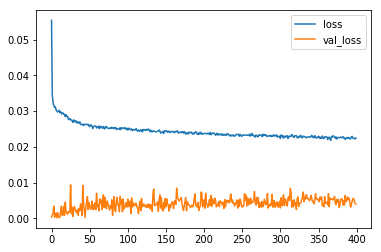

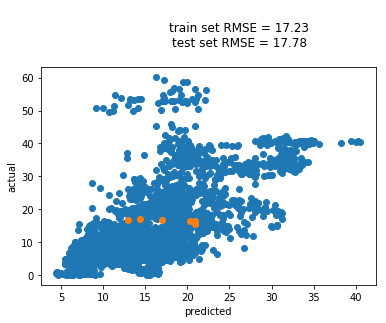

Processing 808
Train on 2871 samples, validate on 47 samples
Epoch 1/400
 - 6s - loss: 0.0563 - mean_squared_error: 0.0563 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 2/400
 - 0s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 3/400
 - 1s - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0195 - val_mean_squared_error: 0.0195
Epoch 4/400
 - 1s - loss: 0.0310 - mean_squared_error: 0.0310 - val_loss: 0.0318 - val_mean_squared_error: 0.0318
Epoch 5/400
 - 1s - loss: 0.0306 - mean_squared_error: 0.0306 - val_loss: 0.0282 - val_mean_squared_error: 0.0282
Epoch 6/400
 - 1s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0256 - val_mean_squared_error: 0.0256
Epoch 7/400
 - 1s - loss: 0.0303 - mean_squared_error: 0.0303 - val_loss: 0.0233 - val_mean_squared_error: 0.0233
Epoch 8/400
 - 1s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0200 - val_mean_squared_error: 0.0200
Epoch 9/400
 - 1s - loss: 0

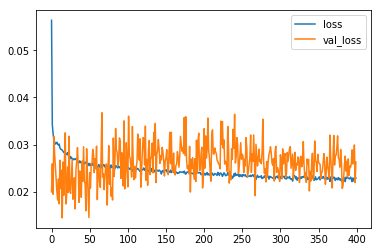

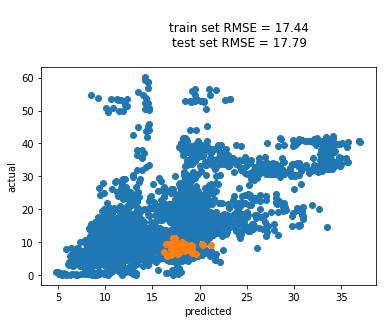

Processing 2006
Train on 2878 samples, validate on 40 samples
Epoch 1/400
 - 6s - loss: 0.0560 - mean_squared_error: 0.0560 - val_loss: 0.1032 - val_mean_squared_error: 0.1032
Epoch 2/400
 - 0s - loss: 0.0331 - mean_squared_error: 0.0331 - val_loss: 0.0867 - val_mean_squared_error: 0.0867
Epoch 3/400
 - 0s - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0755 - val_mean_squared_error: 0.0755
Epoch 4/400
 - 0s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0909 - val_mean_squared_error: 0.0909
Epoch 5/400
 - 0s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0857 - val_mean_squared_error: 0.0857
Epoch 6/400
 - 1s - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0862 - val_mean_squared_error: 0.0862
Epoch 7/400
 - 0s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0741 - val_mean_squared_error: 0.0741
Epoch 8/400
 - 1s - loss: 0.0297 - mean_squared_error: 0.0297 - val_loss: 0.0718 - val_mean_squared_error: 0.0718
Epoch 9/400
 - 1s - loss: 

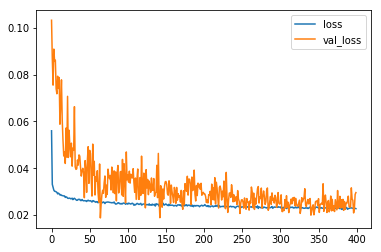

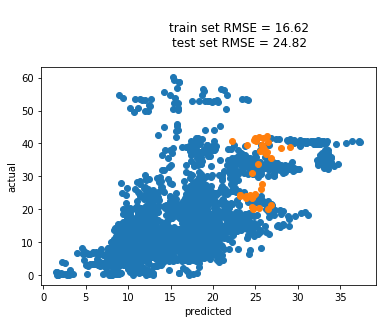

Processing 2015
Train on 2878 samples, validate on 40 samples
Epoch 1/400
 - 15s - loss: 0.0551 - mean_squared_error: 0.0551 - val_loss: 0.0279 - val_mean_squared_error: 0.0279
Epoch 2/400
 - 1s - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0223 - val_mean_squared_error: 0.0223
Epoch 3/400
 - 1s - loss: 0.0330 - mean_squared_error: 0.0330 - val_loss: 0.0158 - val_mean_squared_error: 0.0158
Epoch 4/400
 - 1s - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 5/400
 - 1s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0183 - val_mean_squared_error: 0.0183
Epoch 6/400
 - 1s - loss: 0.0313 - mean_squared_error: 0.0313 - val_loss: 0.0230 - val_mean_squared_error: 0.0230
Epoch 7/400
 - 1s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 8/400
 - 1s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0175 - val_mean_squared_error: 0.0175
Epoch 9/400
 - 1s - loss:

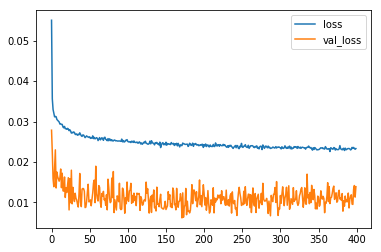

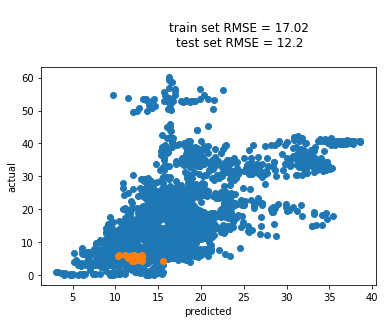

Processing 2019
Train on 2867 samples, validate on 51 samples
Epoch 1/400
 - 16s - loss: 0.0549 - mean_squared_error: 0.0549 - val_loss: 0.0320 - val_mean_squared_error: 0.0320
Epoch 2/400
 - 1s - loss: 0.0350 - mean_squared_error: 0.0350 - val_loss: 0.0360 - val_mean_squared_error: 0.0360
Epoch 3/400
 - 1s - loss: 0.0332 - mean_squared_error: 0.0332 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 4/400
 - 1s - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 5/400
 - 1s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0376 - val_mean_squared_error: 0.0376
Epoch 6/400
 - 1s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 7/400
 - 1s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0413 - val_mean_squared_error: 0.0413
Epoch 8/400
 - 1s - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 9/400
 - 1s - loss:

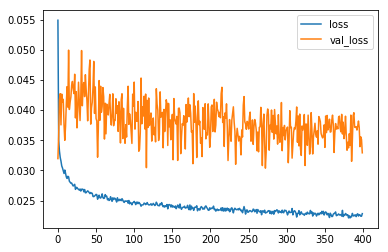

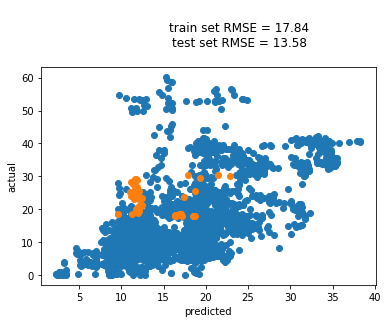

Processing 2021
Train on 2880 samples, validate on 38 samples
Epoch 1/400
 - 18s - loss: 0.0552 - mean_squared_error: 0.0552 - val_loss: 0.0044 - val_mean_squared_error: 0.0044
Epoch 2/400
 - 1s - loss: 0.0367 - mean_squared_error: 0.0367 - val_loss: 0.0060 - val_mean_squared_error: 0.0060
Epoch 3/400
 - 1s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/400
 - 1s - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 5/400
 - 1s - loss: 0.0315 - mean_squared_error: 0.0315 - val_loss: 0.0062 - val_mean_squared_error: 0.0062
Epoch 6/400
 - 1s - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 7/400
 - 1s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0071 - val_mean_squared_error: 0.0071
Epoch 8/400
 - 1s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0138 - val_mean_squared_error: 0.0138
Epoch 9/400
 - 1s - loss:

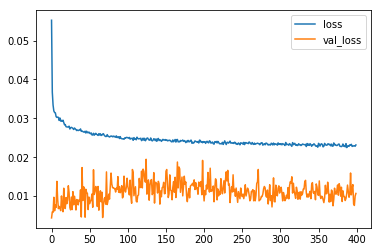

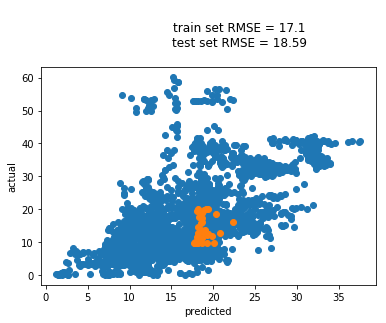

Processing 2069
Train on 2880 samples, validate on 38 samples
Epoch 1/400
 - 18s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0402 - val_mean_squared_error: 0.0402
Epoch 2/400
 - 1s - loss: 0.0342 - mean_squared_error: 0.0342 - val_loss: 0.0327 - val_mean_squared_error: 0.0327
Epoch 3/400
 - 1s - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.0340 - val_mean_squared_error: 0.0340
Epoch 4/400
 - 1s - loss: 0.0321 - mean_squared_error: 0.0321 - val_loss: 0.0299 - val_mean_squared_error: 0.0299
Epoch 5/400
 - 1s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0374 - val_mean_squared_error: 0.0374
Epoch 6/400
 - 1s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0281 - val_mean_squared_error: 0.0281
Epoch 7/400
 - 1s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 8/400
 - 1s - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 9/400
 - 1s - loss:

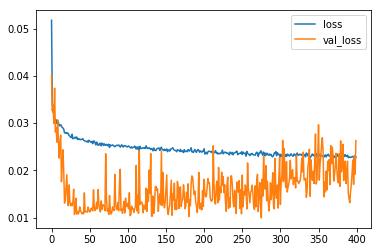

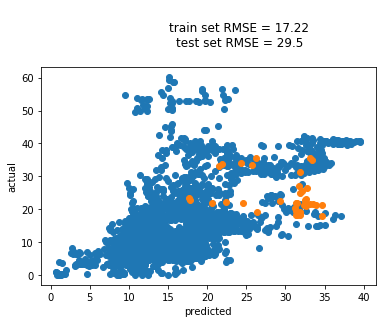

Processing 2074
Train on 2878 samples, validate on 40 samples
Epoch 1/400
 - 19s - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0099 - val_mean_squared_error: 0.0099
Epoch 2/400
 - 1s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0120 - val_mean_squared_error: 0.0120
Epoch 3/400
 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 4/400
 - 1s - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 5/400
 - 1s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 0.0135 - val_mean_squared_error: 0.0135
Epoch 6/400
 - 1s - loss: 0.0311 - mean_squared_error: 0.0311 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 7/400
 - 1s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0168 - val_mean_squared_error: 0.0168
Epoch 8/400
 - 1s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0139 - val_mean_squared_error: 0.0139
Epoch 9/400
 - 1s - loss:

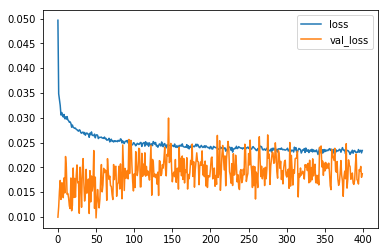

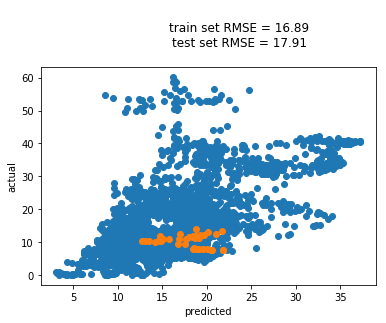

Processing 2106
Train on 2880 samples, validate on 38 samples
Epoch 1/400
 - 21s - loss: 0.0504 - mean_squared_error: 0.0504 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 2/400
 - 1s - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0110 - val_mean_squared_error: 0.0110
Epoch 3/400
 - 1s - loss: 0.0334 - mean_squared_error: 0.0334 - val_loss: 0.0097 - val_mean_squared_error: 0.0097
Epoch 4/400
 - 1s - loss: 0.0326 - mean_squared_error: 0.0326 - val_loss: 0.0103 - val_mean_squared_error: 0.0103
Epoch 5/400
 - 1s - loss: 0.0316 - mean_squared_error: 0.0316 - val_loss: 0.0098 - val_mean_squared_error: 0.0098
Epoch 6/400
 - 1s - loss: 0.0307 - mean_squared_error: 0.0307 - val_loss: 0.0106 - val_mean_squared_error: 0.0106
Epoch 7/400
 - 1s - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0085 - val_mean_squared_error: 0.0085
Epoch 8/400
 - 1s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0127 - val_mean_squared_error: 0.0127
Epoch 9/400
 - 1s - loss:

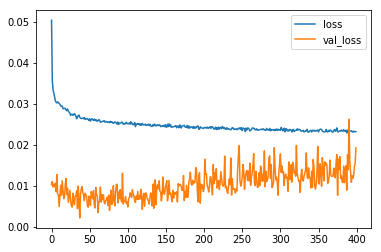

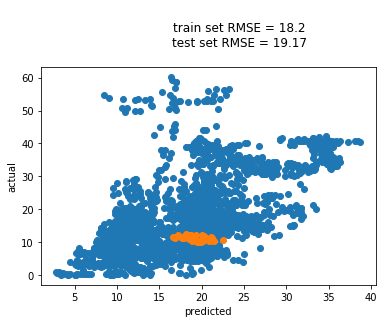

Processing 2107
Train on 2915 samples, validate on 3 samples
Epoch 1/400
 - 21s - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 1.4758e-04 - val_mean_squared_error: 1.4755e-04
Epoch 2/400
 - 1s - loss: 0.0336 - mean_squared_error: 0.0336 - val_loss: 2.2084e-04 - val_mean_squared_error: 2.2081e-04
Epoch 3/400
 - 1s - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 4.1407e-05 - val_mean_squared_error: 4.1377e-05
Epoch 4/400
 - 1s - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 6.0106e-05 - val_mean_squared_error: 6.0075e-05
Epoch 5/400
 - 1s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 4.3587e-04 - val_mean_squared_error: 4.3584e-04
Epoch 6/400
 - 1s - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 3.7320e-05 - val_mean_squared_error: 3.7289e-05
Epoch 7/400
 - 1s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 3.0462e-04 - val_mean_squared_error: 3.0459e-04
Epoch 8/400
 - 1s - loss: 0.0305 - mean_squared_error: 0.0305 - val_loss: 2.4612e-04

KeyboardInterrupt: 

In [38]:
for i in df.site.unique():

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.rzsm
    X_test = sdf.drop(["site","rzsm"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.rzsm 
    X_train = nsdf.drop(["site","rzsm"], axis=1)
        
    # Scale data
#     transformer_x = StandardScaler().fit(X_train)
#     transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
    transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
    transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 4
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 19))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 19))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 400,
                    batch_size=75,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mean_squared_error']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()


    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [ ]:
for i in df.site.unique():
    sdf = df[df.site == i]
    max_len = 0
    if len(sdf)>max_len:
        max_len = len(sdf)
        answer = i
    else:
        continue

In [ ]:
answer